In [33]:
from typing import (
    List,
    Dict,
    Tuple,
    Optional,
)

import os
import sys

import pandas as pd
import altair as alt
import csv

DATA_PATH = 'data/weak_experiment_results/CADEC_ADR'
METRICS = {
    'active valid/ADR/f1': 'F1',
    'active valid/ADR/precision': 'Precesion',
    'active valid/ADR/recall': 'Recall',
}
DataDef = List[
    Dict[str, object]
]

In [34]:
def parse_file(file_name: str, experiment_tag: str, trial_num: int, weak_weight: float) -> DataDef:
    output = []
    with open(file_name, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            # tag, value, step
            metric_name, metric_val, step = row
            if metric_name not in METRICS:
                continue
            output.append({
                'metric_name': METRICS[metric_name],
                'metric_val': round(float(metric_val), 2),
                'step': float(step),
                'tag': experiment_tag,
                'trial_num': trial_num,
                'weak_weight': weak_weight,
            })
    return output

def get_weak_experiment_data(root_dir: str) -> DataDef:
    # weak_weight -> trial_num -> summary_file
    result: DataDef = []
    for file in os.listdir(root_dir):
        if not file.startswith('weak_'):
            continue
        weak_weight = float(file[len('weak_'):])
        weight_dir = os.path.join(root_dir, file)
        for trial_file in os.listdir(weight_dir):
            prefix = 'CADEC_ADR_word_elmo_bi_lstm_trial_'
            if not trial_file.startswith(prefix):
                print(f'skipping: {trial_file}')
                continue
            trial_num = int(trial_file[len(prefix):])
            summary_file = os.path.join(weight_dir, trial_file, 'summary.csv')
            experiment_data = parse_file(summary_file, 'ADR', trial_num, weak_weight)
            result.extend(experiment_data)
    return result
experiment_data = get_weak_experiment_data(DATA_PATH)

skipping: CADEC_ADR_phrase_elmo_bi_lstm_trial_2
skipping: CADEC_ADR_phrase_elmo_bi_lstm_trial_4
skipping: CADEC_ADR_phrase_elmo_bi_lstm_trial_3
skipping: CADEC_ADR_phrase_elmo_bi_lstm_trial_1
skipping: CADEC_ADR_phrase_elmo_bi_lstm_trial_0


In [36]:
data_frame = pd.DataFrame(experiment_data)
data_frame.head(2)

,metric_name,metric_val,step,tag,trial_num,weak_weight
0,Precesion,0.03,1.0,ADR,2,0.01
1,Precesion,0.04,6.0,ADR,2,0.01


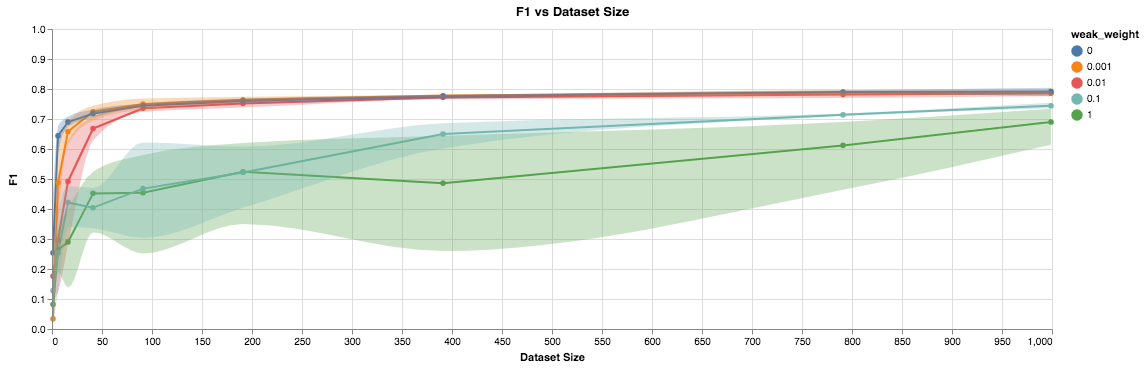

In [52]:
WEAK_WEIGHT = 1.0
MAX_DATASET_SIZE = 10000

def metric_graph(data_frame: pd.DataFrame, metric: str) -> alt.Chart:
    base = alt.Chart(data_frame, title=f'{metric} vs Dataset Size')
    line = base.mark_line(point=True).encode(
        x=alt.X('step', title='Dataset Size'),
        y=alt.Y('mean(metric_val)', title=metric, scale=alt.Scale(domain=[0, 1])),
        color='weak_weight:N',
    ).transform_filter(
        alt.datum.metric_name == metric
    ).transform_filter(
        alt.datum.weak_weight <= WEAK_WEIGHT
    ).transform_filter(
        alt.datum.step <= MAX_DATASET_SIZE
    )
    
    confidence_interval = base.mark_area(interpolate='monotone', opacity=0.3).encode(
        x=alt.X('step'),
        y=alt.Y('ci0(metric_val)', scale=alt.Scale(domain=[0, 1])),
        y2='ci1(metric_val)',
        color='weak_weight:N',
    ).transform_filter(
        alt.datum.metric_name == metric
    ).transform_filter(
        alt.datum.weak_weight <= WEAK_WEIGHT
    ).transform_filter(
        alt.datum.step <= MAX_DATASET_SIZE
    )

    return (line + confidence_interval).properties(width=1000)
metric_graph(data_frame, 'F1')